<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/Polyakov-Alexander-branch/Polyakov%20Alexander/VGG16_3_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Подготовка

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_DIR = '/content/drive/MyDrive/AI/datasets/arches/train/'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [4]:
datagen_train = ImageDataGenerator(rescale=1./255, validation_split=0.2)

datagen_train = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,      # использовать 10% данных для валидации
    rotation_range=20,         # случайный поворот на ±10 градусов
    width_shift_range=0.1,     # случайный сдвиг по ширине на ±10%
    height_shift_range=0.1,    # случайный сдвиг по высоте на ±10%
    zoom_range=0.2,            # случайное увеличение/уменьшение на ±20%
    horizontal_flip=True,      # случайное отражение по горизонтали
    brightness_range=[0.2, 0.5] # изменение яркости от 80% до 120%
)


train_generator = datagen_train.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_train.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1080 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


### Обучение лучшей модели

In [5]:
best_model_dir = '/content/drive/MyDrive/AI/datasets/arches/best_models/'


In [17]:
# Загрузка базовой модели VGG16
base_model = VGG16(weights='imagenet', include_top=True)

# Продолжение модели с дополнительными слоями
x = base_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Собрать итоговую модель
model = Model(inputs=base_model.input, outputs=predictions)

# Отключение обучения базовых слоев
for layer in base_model.layers:
    layer.trainable = False

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

553467096/553467096 [==============================] - 25s 0us/step


In [20]:
checkpoint_callback = ModelCheckpoint(
    best_model_dir + 'best_model_VGG16_val_accuracy.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 0.5212 - accuracy: 0.8259
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to /content/drive/MyDrive/AI/datasets/arches/best_models/best_model_VGG16_val_accuracy.h5
34/34 [==============================] - 46s 1s/step - loss: 0.5212 - accuracy: 0.8259 - val_loss: 0.5026 - val_accuracy: 0.8000
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.8102
Epoch 2: val_accuracy improved from 0.80000 to 0.82500, saving model to /content/drive/MyDrive/AI/datasets/arches/best_models/best_model_VGG16_val_accuracy.h5
34/34 [==============================] - 44s 1s/step - loss: 0.5119 - accuracy: 0.8102 - val_loss: 0.5015 - val_accuracy: 0.8250
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.8148
Epoch 3: val_accuracy did not improve from 0.82500
34/34 [==============================] - 38s 1s/step - loss: 0.4927 - accuracy: 0.8148 - va

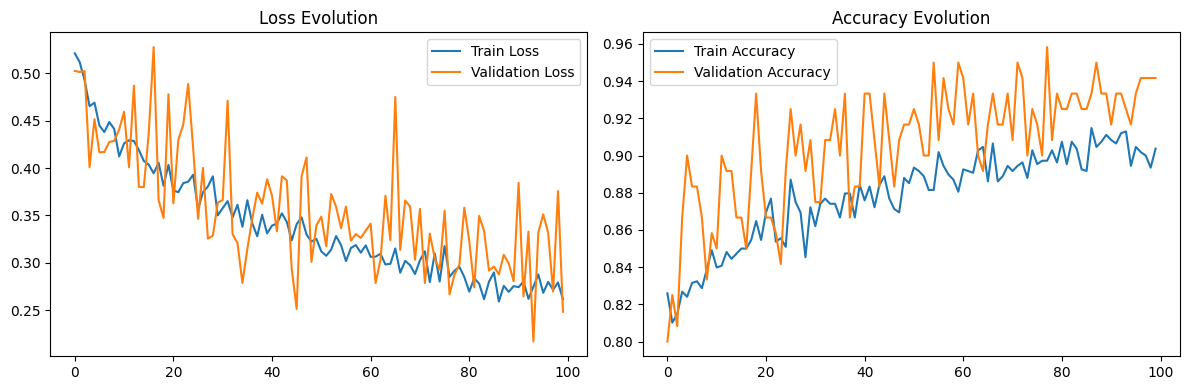

In [21]:
import matplotlib.pyplot as plt

# Визуализация потерь
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

# Визуализация точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
datagen = ImageDataGenerator(rescale=1./255)
plt.show()

In [22]:
from tensorflow.keras.models import load_model

best_model_dir = '/content/drive/MyDrive/AI/datasets/arches/best_models/'

model = load_model(best_model_dir + 'best_model_VGG16_val_accuracy.h5')

In [23]:
TEST_DIR = '/content/drive/MyDrive/AI/datasets/arches/test/'
datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')


Found 214 images belonging to 3 classes.
7/7 [==============================] - 84s 14s/step - loss: 0.5537 - accuracy: 0.8271
Test accuracy: 0.827102780342102


7/7 [==============================] - 2s 321ms/step


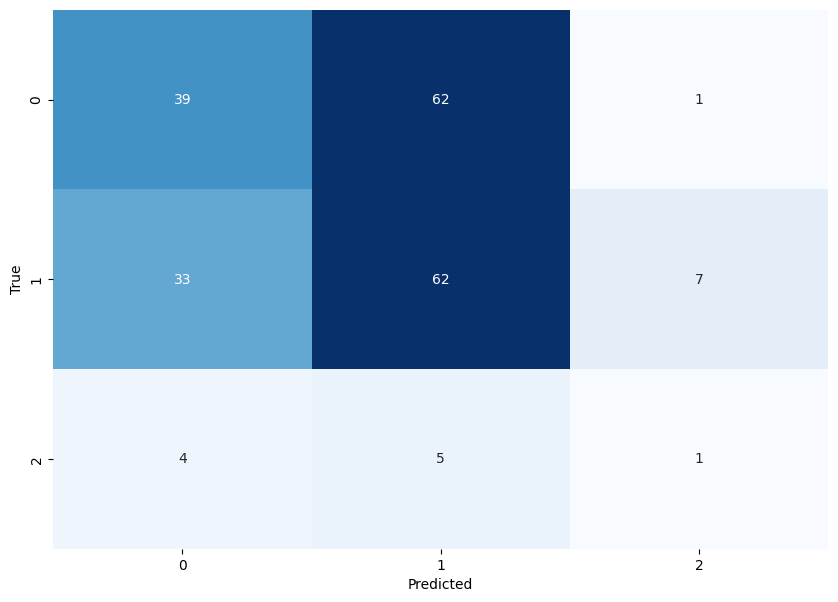

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Получить предсказания модели
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)

# Получить метки классов
y_true = test_generator.classes

# Вычислить confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Отобразить confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()